In [3]:
from sklearn.ensemble import RandomForestRegressor
import copy
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import time
import datetime, calendar
import scipy.stats as stats
import statsmodels.api as sm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Mecab
import nltk
import re
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Mecab
from tensorflow.keras import layers, models
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

ModuleNotFoundError: No module named 'torchvision'

In [4]:
train_data = pd.read_csv('train.csv')
train_data.index = pd.to_datetime(train_data['일자'])
lunch_menu = train_data['중식메뉴']
del train_data['조식메뉴'], train_data['중식메뉴'], train_data['석식메뉴'], train_data['일자']


cases = pd.read_csv('일일코로나확진자.csv')
cases = cases[(cases['Entity'] == 'South Korea')].iloc[:, [2, 3]].reset_index(drop=True)
cases.index = pd.to_datetime(cases['Day'])
del cases['Day']
cases.columns = ['확진자수']
cases = cases[cases.index < '2021-04-10']


temp = pd.read_csv('진주시_기온정보.csv', encoding='euc-kr')
temp.index = pd.to_datetime(temp['날짜'])
del temp['날짜'], temp['지점'], temp['최저기온(℃)']

hum = pd.read_csv('진주시강수량.csv', encoding='euc-kr')
hum.index = pd.to_datetime(hum['날짜'])
del hum['날짜'], hum['지점']
hum.fillna(0, inplace=True)


heat_idx = pd.read_csv('진주시_열지수_정보.csv', encoding='euc-kr')
heat_idx['일자'] = heat_idx['일자'].apply(lambda row: str(row)[:4] + '-' + str(row)[4:6] + '-' + str(row)[-2:])
heat_idx.index = pd.to_datetime(heat_idx['일자'])
heat_idx = heat_idx.loc[:, ['습도(%)']]

train_data = pd.concat([train_data, temp, cases, hum, heat_idx], axis=1)
train_data = train_data[~train_data['본사정원수'].isnull()].fillna(0.)
train_data.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,평균기온(℃),최고기온(℃),확진자수,강수량(mm),습도(%)
2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,-0.6,5.0,0.0,0.0,44.1
2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,867.0,560.0,-2.3,6.2,0.0,0.0,47.2
2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,1017.0,573.0,-1.7,7.7,0.0,0.0,56.2
2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,978.0,525.0,-0.2,7.7,0.0,0.0,55.3
2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,925.0,330.0,1.3,9.6,0.0,0.0,42.7


In [5]:
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(np.ceil(adjusted_dom/7.0)))


def MunhwaDay(row):
    if row['요일'] == '수' and row['석식계'] == 0 and int(row['주차'][0]) >= 4 :
        return 1
    else:
        return 0
    
def LastWedInMonth(year, month, date):

    daysInMonth = calendar.monthrange(year, month)[1]   
    dt = datetime.date(year, month, daysInMonth)

    offset = 3 - dt.isoweekday()
    if offset > 0: offset -= 7                         
    dt += datetime.timedelta(offset)                   

    if dt == date:
        return 1
    else:
        return 0
    
train_data['개월'] = [f'{date.month}월' for date in train_data.index]
train_data['주차'] = [f'{week_of_month(date)}주차' for date in train_data.index]
train_data['문화day'] = train_data.apply(lambda row : MunhwaDay(row), axis=1)

test_data = pd.read_csv('test.csv')
test_data.index = pd.to_datetime(test_data['일자'])
del test_data['조식메뉴'], test_data['중식메뉴'], test_data['석식메뉴'], test_data['일자']
test_data = pd.concat([test_data, temp, cases, hum, heat_idx], axis=1)
test_data = test_data[~test_data['본사정원수'].isnull()].fillna(0.)
test_data['개월'] = [f'{date.month}월' for date in test_data.index]
test_data['주차'] = [f'{week_of_month(date)}주차' for date in test_data.index]
#test_data['문화day'] = [LastWedInMonth(date.year, date.month, date) for date in test_data.index]
test_data['문화day'] = [0 for i in range(len(test_data))]
whole_df = pd.concat([train_data, test_data], axis=0)

# Feature Simplification

In [6]:
def TempClass(row):
    if row >= 30:
        return 'temp30'
    elif row >= 20:
        return 'temp20'
    elif row >= 10:
        return 'temp10'
    elif row >= 0:
        return 'temp0'
    elif row >= -10:
        return 'temp-10'
    else:
        return 'temp-20'
    
def HumidClass(row):
    if row >= 70:
        return 'Humid High'
    elif row >= 30:
        return 'Humid Middle'
    else:
        return 'Humid Low'
    

In [7]:
whole_df['본사출근자수'] = whole_df['본사정원수'] - whole_df['본사휴가자수'] - whole_df['본사출장자수'] - whole_df['현본사소속재택근무자수']
whole_df['중식 참여율'] = whole_df['중식계'] / whole_df['본사출근자수']
whole_df['석식 참여율'] = whole_df['석식계'] / whole_df['본사출근자수']
whole_df['시간외근무율'] = whole_df['본사시간외근무명령서승인건수'] / whole_df['본사출근자수']
whole_df['평균기온'] = whole_df['평균기온(℃)'].apply(TempClass)
whole_df['최고기온'] = whole_df['최고기온(℃)'].apply(TempClass)
whole_df['습도'] = whole_df['습도(%)'].apply(HumidClass)
del whole_df['본사정원수'], whole_df['본사휴가자수'], whole_df['본사출장자수'], whole_df['현본사소속재택근무자수']
del whole_df['중식계'], whole_df['석식계'], whole_df['본사시간외근무명령서승인건수']
del whole_df['평균기온(℃)'], whole_df['최고기온(℃)'], whole_df['습도(%)']
whole_df

,요일,확진자수,강수량(mm),개월,주차,문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,평균기온,최고기온,습도
2016-02-01,월,0.0,0.0,2월,1주차,0,2401.0,0.432736,0.137859,0.099125,temp-10,temp0,Humid Middle
2016-02-02,화,0.0,0.0,2월,1주차,0,2378.0,0.364592,0.235492,0.134146,temp-10,temp0,Humid Middle
2016-02-03,수,0.0,0.0,2월,1주차,0,2365.0,0.430021,0.242283,0.046934,temp-10,temp0,Humid Middle
2016-02-04,목,0.0,0.0,2월,1주차,0,2277.0,0.429513,0.230567,0.155907,temp-10,temp0,Humid Middle
2016-02-05,금,0.0,0.0,2월,1주차,0,2142.0,0.431839,0.154062,0.015873,temp0,temp0,Humid Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,월,478.0,0.0,4월,2주차,0,2343.0,NaN,NaN,0.300469,temp10,temp10,Humid Middle
2021-04-06,화,668.0,0.0,4월,2주차,0,2363.0,NaN,NaN,0.269149,temp10,temp20,Humid Middle
2021-04-07,수,700.0,0.0,4월,2주차,0,2329.0,NaN,NaN,0.000429,temp10,temp20,Humid Middle
2021-04-08,목,671.0,0.0,4월,2주차,0,2306.0,NaN,NaN,0.220729,temp10,temp20,Humid Middle


In [8]:
#공휴일(설,추석 등의 전날은 석식 참여율이 굉장히 낮음)
whole_df[(whole_df['석식 참여율'] < 0.1) & (whole_df['석식 참여율'] > 0.)]

,요일,확진자수,강수량(mm),개월,주차,문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,평균기온,최고기온,습도
2016-12-22,목,0.0,11.0,12월,4주차,0,2345.0,0.223454,0.090832,0.013646,temp10,temp10,Humid Middle
2017-01-26,목,0.0,0.0,1월,5주차,0,2211.0,0.381728,0.066486,0.012664,temp-10,temp0,Humid Middle
2017-12-26,화,0.0,0.0,12월,5주차,0,2171.0,0.421465,0.081069,0.028558,temp0,temp0,Humid Middle
2018-12-24,월,0.0,0.0,12월,5주차,0,1793.0,0.165086,0.058003,0.014501,temp0,temp0,Humid Middle
2018-12-31,월,0.0,0.0,12월,6주차,0,1629.0,0.203806,0.082873,0.017188,temp-10,temp0,Humid Middle
2019-02-01,금,0.0,0.0,2월,1주차,0,2343.0,0.343150,0.072983,0.000854,temp-10,temp0,Humid Middle
2019-09-11,수,0.0,1.8,9월,3주차,0,2550.0,0.359216,0.048235,0.000000,temp20,temp30,Humid High
2019-12-23,월,0.0,0.0,12월,5주차,0,2540.0,0.291732,0.048819,0.051575,temp0,temp10,Humid High
2019-12-24,화,0.0,0.0,12월,5주차,0,2417.0,0.191146,0.091436,0.021514,temp0,temp10,Humid High
2019-12-26,목,0.0,1.2,12월,5주차,0,2324.0,0.255594,0.087349,0.064974,temp0,temp0,Humid High


In [9]:
#print(whole_df[whole_df['중식 참여율'] < 0.25]['요일'].value_counts())

#print(whole_df[whole_df['중식 참여율'] < 0.25]['개월'].value_counts())
#
#print(whole_df[whole_df['중식 참여율'] < 0.25]['주차'].value_counts())
#
#print(whole_df[whole_df['중식 참여율'] < 0.25]['평균기온'].value_counts())
#
#print(whole_df[whole_df['중식 참여율'] < 0.25]['최고기온'].value_counts())
#
#print(whole_df[whole_df['중식 참여율'] < 0.25]['습도'].value_counts())

- 주로 4,5주차 금요일에 중식 참여율이 매우 떨어지는 경우가 발생함.

In [10]:
plt.plot(whole_df.groupby('평균기온')['중식 참여율'].mean());

NameError: name 'plt' is not defined

In [11]:
plt.plot(whole_df.groupby('평균기온')['석식 참여율'].mean());

NameError: name 'plt' is not defined

In [12]:
def PreHolyday(row, pre_hol):
    if row in pre_hol.values:
        return 1
    else:
        return 0
    
pre_hol = pd.read_csv('pre_holiday.txt', encoding='utf8')
pre_hol = pd.to_datetime(pre_hol['공휴일전평일'])
whole_df['pre공휴일'] = [PreHolyday(date, pre_hol) for date in whole_df.index]

FileNotFoundError: [Errno 2] No such file or directory: 'pre_holiday.txt'

In [13]:
whole_df.head()

,요일,확진자수,강수량(mm),개월,주차,문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,평균기온,최고기온,습도
2016-02-01,월,0.0,0.0,2월,1주차,0,2401.0,0.432736,0.137859,0.099125,temp-10,temp0,Humid Middle
2016-02-02,화,0.0,0.0,2월,1주차,0,2378.0,0.364592,0.235492,0.134146,temp-10,temp0,Humid Middle
2016-02-03,수,0.0,0.0,2월,1주차,0,2365.0,0.430021,0.242283,0.046934,temp-10,temp0,Humid Middle
2016-02-04,목,0.0,0.0,2월,1주차,0,2277.0,0.429513,0.230567,0.155907,temp-10,temp0,Humid Middle
2016-02-05,금,0.0,0.0,2월,1주차,0,2142.0,0.431839,0.154062,0.015873,temp0,temp0,Humid Middle


In [14]:
day_dummy = pd.get_dummies(whole_df['요일'])
month_dummy = pd.get_dummies(whole_df['개월'])
week_dummy = pd.get_dummies(whole_df['주차'])
avgtemp_dummy = pd.get_dummies(whole_df[['평균기온']])
hightemp_dummy = pd.get_dummies(whole_df[['최고기온']])
humid_dummy = pd.get_dummies(whole_df['습도'])
whole_df = pd.concat([whole_df, day_dummy, month_dummy, week_dummy,
                      avgtemp_dummy, hightemp_dummy, humid_dummy], axis=1)
drop_cols = ['요일', '개월', '주차', '평균기온', '최고기온', '습도']
whole_df.drop(drop_cols, axis=1, inplace=True)
whole_df = sm.add_constant(whole_df)
train_y_lunch = whole_df['중식 참여율'].dropna()
train_y_dinner = whole_df['석식 참여율'].dropna()
del whole_df['중식 참여율'], whole_df['석식 참여율']

NameError: name 'sm' is not defined

In [15]:
whole_df['4주x금요일'] = whole_df['4주차'] * whole_df['금']
whole_df['5주x금요일'] = whole_df['5주차'] * whole_df['금']
whole_df.head()

,확진자수,강수량(mm),문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,금,목,수,...,최고기온_temp-10,최고기온_temp0,최고기온_temp10,최고기온_temp20,최고기온_temp30,Humid High,Humid Low,Humid Middle,4주x금요일,5주x금요일
2016-02-01,0.0,0.0,0,2401.0,0.432736,0.137859,0.099125,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2016-02-02,0.0,0.0,0,2378.0,0.364592,0.235492,0.134146,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2016-02-03,0.0,0.0,0,2365.0,0.430021,0.242283,0.046934,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2016-02-04,0.0,0.0,0,2277.0,0.429513,0.230567,0.155907,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2016-02-05,0.0,0.0,0,2142.0,0.431839,0.154062,0.015873,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [16]:
train_x, test_x = copy.deepcopy(whole_df.iloc[:len(train_data),:]), copy.deepcopy(whole_df.iloc[len(train_data):,:])
rain_min = train_x['강수량(mm)'].min()
rain_max = train_x['강수량(mm)'].max()
train_x['강수량(mm)'] = (train_x['강수량(mm)'] - rain_min) / (rain_max - rain_min)
test_x['강수량(mm)'] = (test_x['강수량(mm)'] - rain_min) / (rain_max - rain_min)

case_min = train_x['확진자수'].min()
case_max = train_x['확진자수'].max()

train_x['확진자수'] = (train_x['확진자수'] - case_min) / (case_max - case_min)
test_x['확진자수'] = (test_x['확진자수'] - case_min) / (case_max - case_min)

to_min = train_x['본사출근자수'].min()
to_max = train_x['본사출근자수'].max()

train_x['본사출근자수'] = (train_x['본사출근자수'] - to_min) / (to_max - to_min)
test_x['본사출근자수'] = (test_x['본사출근자수'] - to_min) / (to_max - to_min)

In [17]:
res1 = sm.OLS(train_y_lunch, train_x, missing='drop').fit()
res1.summary()

NameError: name 'sm' is not defined

In [18]:
res2 = sm.OLS(train_y_dinner, train_x, missing='drop').fit()
res2.summary()

NameError: name 'sm' is not defined

In [19]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (res1.predict(test_x) * whole_df['본사출근자수'][1205:]).values
sub['석식계'] = (res2.predict(test_x) * whole_df['본사출근자수'][1205:]).values
sub.to_csv('submission_reg1.csv', index=False)
sub

NameError: name 'res1' is not defined

In [20]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(res1.predict(train_x).rolling(7).mean())
plt.plot(res1.predict(test_x).rolling(7).mean())
#90

NameError: name 'plt' is not defined

In [21]:
plt.plot(train_y_dinner.rolling(7).mean())
plt.plot(res2.predict(train_x).rolling(7).mean())
plt.plot(res2.predict(test_x).rolling(7).mean())

NameError: name 'plt' is not defined

# Random Forest

In [22]:
model_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
model_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)

In [23]:
model_lunch.fit(train_x, train_y_lunch)
model_dinner.fit(train_x, train_y_dinner)

NameError: name 'train_y_lunch' is not defined

In [24]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (model_lunch.predict(test_x) * test_x['본사출근자수']).values
sub['석식계'] = (model_dinner.predict(test_x) * test_x['본사출근자수']).values
#sub.to_csv('submission_RForest.csv', index=False)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

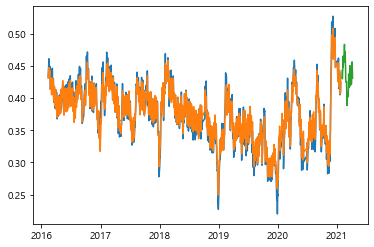

In [63]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(model_lunch.predict(train_x), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(model_lunch.predict(test_x), index=test_x.index).rolling(7).mean())
#82

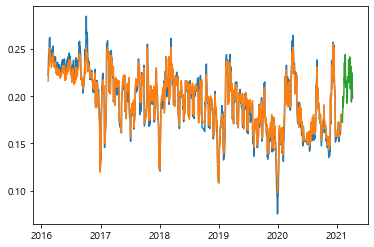

In [64]:
plt.plot(train_y_dinner.rolling(7).mean())
plt.plot(pd.Series(model_dinner.predict(train_x), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(model_dinner.predict(test_x), index=test_x.index).rolling(7).mean())

In [37]:
x = train_x.iloc[:-100,:].values
y_lunch = train_y_lunch[:-100].values
y_dinner = train_y_dinner[:-100].values

x_val = train_x.iloc[-100:, :].values
y_lunch_val = train_y_lunch[-100:].values
y_dinner_val = train_y_dinner[-100:].values


In [40]:
from keras import layers, models


lunch = models.Sequential()
lunch.add(layers.Dense(16, activation='relu', input_shape=(44,)))
lunch.add(layers.Dense(4, activation='relu'))
lunch.add(layers.Dense(1))

lunch.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = lunch.fit(train_x.values[:, 1:], train_y_lunch.values,
                    epochs = 30, batch_size=128,
                    verbose=0)

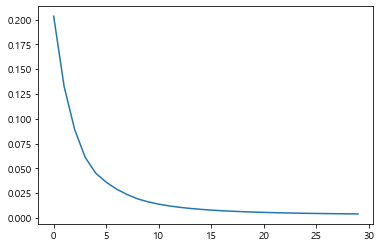

In [41]:
plt.plot(history.history['loss']);
#plt.plot(history.history['val_loss']);

In [42]:
dinner = models.Sequential()
dinner.add(layers.Dense(16, activation='relu', input_shape=(44,)))
dinner.add(layers.Dense(4, activation='relu'))
dinner.add(layers.Dense(1))

dinner.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = dinner.fit(train_x.values[:, 1:], train_y_dinner.values,
                    epochs = 30, batch_size=128,
                    verbose=0)

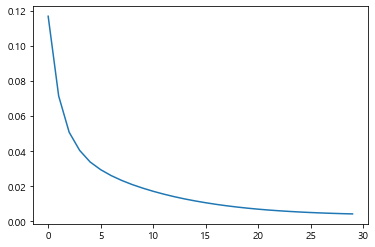

In [43]:
plt.plot(history.history['loss']);
#plt.plot(history.history['val_loss']);

In [62]:
#deep learning + randomforest + regression
ensemble1 = 0.2 * res1.predict(test_x).values + 0.4 * model_lunch.predict(test_x).flatten() + 0.4 * lunch.predict(test_x.iloc[:,1:]).flatten()
ensemble2 = 0.2 * res2.predict(test_x).values + 0.4 * model_dinner.predict(test_x).flatten() + 0.4 * dinner.predict(test_x.iloc[:,1:]).flatten()

sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (ensemble1 * whole_df['본사출근자수'].values[len(train_data):]).round()
sub['석식계'] = (ensemble2 * whole_df['본사출근자수'].values[len(train_data):]).round()
sub.to_csv('submission_fc+lr+RF.csv', index=False)

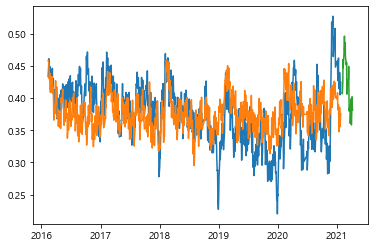

In [68]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(lunch.predict(train_x.iloc[:,1:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(lunch.predict(test_x.iloc[:,1:]).flatten(), index=test_x.index).rolling(7).mean())
#100

# LSTM

- test data가 1월 27일부터이니 1월 20일~4/9까지로 test dataset 재구성하기

- train_data를 2016/2/5부터 2021/1/20까지로 재구성하기

In [16]:
def Convert(df, lag):
    result = pd.DataFrame(columns=df.columns)
    for i in range(len(df)-lag+1):
        result = result.append(df.iloc[i:i+lag,:])
    return result.values.reshape(-1,lag, len(df.columns))

In [25]:
test_x = pd.concat([train_x.iloc[-6:,:], test_x])

In [26]:
train_x_lstm = Convert(train_x, 7).astype(np.float32)
test_x_lstm = Convert(test_x, 7).astype(np.float32)
#lstm_x_val = train_x_lstm[-100:]
#train_x_lstm = train_x_lstm[:-100]

train_y_lstm_lunch = train_y_lunch[6:]
#lstm_y_lunch_val = train_y_lstm_lunch[-100:]
#train_y_lstm_lunch = train_y_lstm_lunch[:-100]

train_y_lstm_dinner = train_y_dinner[6:]
#lstm_y_dinner_val = train_y_lstm_dinner[-100:]
#train_y_lstm_dinner = train_y_lstm_dinner[:-100]

In [28]:
test_x_lstm.shape

(50, 7, 45)

In [41]:
from keras import layers, models
from scipy.linalg import toeplitz


lstm_lunch = models.Sequential(name="LSTM")
lstm_lunch.add(layers.LSTM(16, input_shape=(7, 44)))
lstm_lunch.add(layers.Dense(4, activation='relu'))
lstm_lunch.add(layers.Dense(1))
lstm_lunch.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                3904      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 3,977
Trainable params: 3,977
Non-trainable params: 0
_________________________________________________________________


In [42]:
lstm_lunch.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = lstm_lunch.fit(train_x_lstm[:,:,1:], train_y_lstm_lunch.values,
                    epochs = 50, batch_size=128,
                    #validation_data=(lstm_x_val[:,:,1:].astype(np.float32), lstm_y_lunch_val.values),
                    verbose=0)

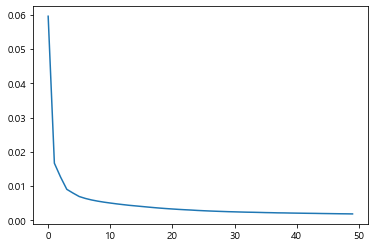

In [43]:
plt.plot(history.history['loss']);
#plt.plot(history.history['val_loss']);

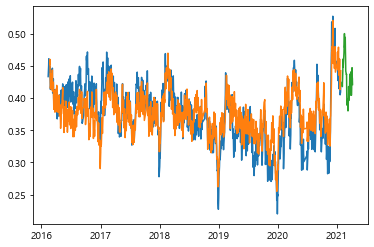

In [53]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(lstm_lunch.predict(train_x_lstm[:,:,1:].astype(float)).flatten(), index=train_y_lstm_lunch.index).rolling(7).mean())
plt.plot(pd.Series(lstm_lunch.predict(test_x_lstm[:,:,1:].astype(float)).flatten(), index=test_x.index[6:]).rolling(7).mean())

In [61]:
lstm_dinner = models.Sequential(name="LSTM")
lstm_dinner.add(layers.LSTM(16, input_shape=(7, 44)))
lstm_dinner.add(layers.Dense(4, activation='relu'))
lstm_dinner.add(layers.Dense(1))
lstm_dinner.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                3904      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 3,977
Trainable params: 3,977
Non-trainable params: 0
_________________________________________________________________


In [62]:
lstm_dinner.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = lstm_dinner.fit(train_x_lstm[:,:,1:], train_y_lstm_dinner.values,
                    epochs = 50, batch_size=128,
                    #validation_data=(lstm_x_val[:,:,1:].astype(np.float32), lstm_y_lunch_val.values),
                    verbose=0)

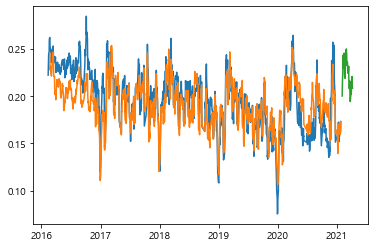

In [63]:
plt.plot(train_y_dinner.rolling(7).mean())
plt.plot(pd.Series(lstm_dinner.predict(train_x_lstm[:,:,1:].astype(float)).flatten(), index=train_y_lstm_dinner.index).rolling(7).mean())
plt.plot(pd.Series(lstm_dinner.predict(test_x_lstm[:,:,1:].astype(float)).flatten(), index=test_x.index[6:]).rolling(7).mean())

In [65]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (lstm_lunch.predict(test_x_lstm[:,:,1:].astype(float)).flatten() * whole_df['본사출근자수'][-50:].values).round()
sub['석식계'] = (lstm_dinner.predict(test_x_lstm[:,:,1:].astype(float)).flatten() * whole_df['본사출근자수'][-50:].values).round()
sub.to_csv('submission_LSTM.csv', index=False)
